In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import dataProcess

from datetime import datetime
import matplotlib.pyplot as plt
import optuna

In [3]:
hourly = 'weatherstats_toronto_hourly.csv'
daily = 'weatherstats_toronto_daily.csv'
start = datetime(2014, 4, 16).date()
end = datetime(2024, 4, 10).date()
data = dataProcess.generateDataNoLoader(hourly, daily, start, end)
train_data = data['train']
val_data = data['validation']
test_data = data['test']

In [12]:
def create_dataloaders(train_data, val_data, test_data, batch_size=2048):
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
  return train_loader, val_loader, test_loader

In [6]:
class WeatherPredictorGRU(nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, num_layers=1, dropout_rate=0.0):
    super(WeatherPredictorGRU, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size1, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
    self.linear1 = nn.Linear(hidden_size1, hidden_size2)
    self.linear2 = nn.Linear(hidden_size2, hidden_size3)
    self.output_linear = nn.Linear(hidden_size3, output_size)
    self.relu = nn.ReLU()

  def forward(self, x):
    out, _ = self.gru(x)
    x = out[:, -1, :]
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    prediction = self.output_linear(x)
    return prediction

In [8]:
def train_model(trial, model, num_epochs, train_loader, val_loader, device):
  criterion = nn.MSELoss()
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

  avg_val_loss = total_val_loss / len(val_loader)
  return avg_val_loss

In [24]:
def objective(trial):
  input_size = 13
  hidden_size1 = trial.suggest_categorical('hidden_size1', [16, 32, 64, 128, 256])
  hidden_size2 = trial.suggest_categorical('hidden_size2', [16, 32, 64, 128, 256])
  hidden_size3 = trial.suggest_categorical('hidden_size3', [16, 32, 64, 128, 256])
  output_size = 1
  num_layers = trial.suggest_int('num_layers', 1, 3)
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = WeatherPredictorGRU(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, num_layers, dropout_rate)
  model.to(device)

  train_loader, val_loader, _ = create_dataloaders(train_data, val_data, test_data)

  num_epochs = 40
  return train_model(trial, model, num_epochs, train_loader, val_loader, device)

In [10]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
  print(f"    {key}: {value}")

[I 2024-04-19 04:26:39,176] A new study created in memory with name: no-name-216fd541-de0f-4241-aacd-dae61efed964
<ipython-input-9-72a247a942b3>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
<ipython-input-8-db0b1521e39d>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-04-19 04:26:40,430] Trial 0 finished with value: 117.94654846191406 and parameters: {'hidden_size1': 32, 'hidden_size2': 32, 'hidden_size3': 256, 'num_layers': 2, 'dropout_rate': 0.1469723265428497, 'lr': 0.0006393116731363774}. Best is trial 0 with value: 117.94654846191406.
[I 2024-04-19 0

Best trial:
  Value: 116.03802490234375
  Params: 
    hidden_size1: 256
    hidden_size2: 64
    hidden_size3: 32
    num_layers: 3
    dropout_rate: 0.189667126879616
    lr: 0.0026448961708292864


Epoch [1/50], Training Loss: 188.1666, Validation Loss: 188.9372
Epoch [2/50], Training Loss: 173.1299, Validation Loss: 157.6433
Epoch [3/50], Training Loss: 135.1119, Validation Loss: 129.7517
Epoch [4/50], Training Loss: 114.4676, Validation Loss: 116.1425
Epoch [5/50], Training Loss: 130.9882, Validation Loss: 119.3476
Epoch [6/50], Training Loss: 115.4438, Validation Loss: 117.9904
Epoch [7/50], Training Loss: 125.8576, Validation Loss: 116.1305
Epoch [8/50], Training Loss: 111.8082, Validation Loss: 118.8574
Epoch [9/50], Training Loss: 119.7750, Validation Loss: 120.5476
Epoch [10/50], Training Loss: 111.3338, Validation Loss: 119.2878
Epoch [11/50], Training Loss: 120.8518, Validation Loss: 116.9645
Epoch [12/50], Training Loss: 105.9624, Validation Loss: 116.0538
Epoch [13/50], Training Loss: 108.5414, Validation Loss: 116.0902
Epoch [14/50], Training Loss: 124.7282, Validation Loss: 116.0415
Epoch [15/50], Training Loss: 111.6402, Validation Loss: 116.3348
Epoch [16/50], Trai

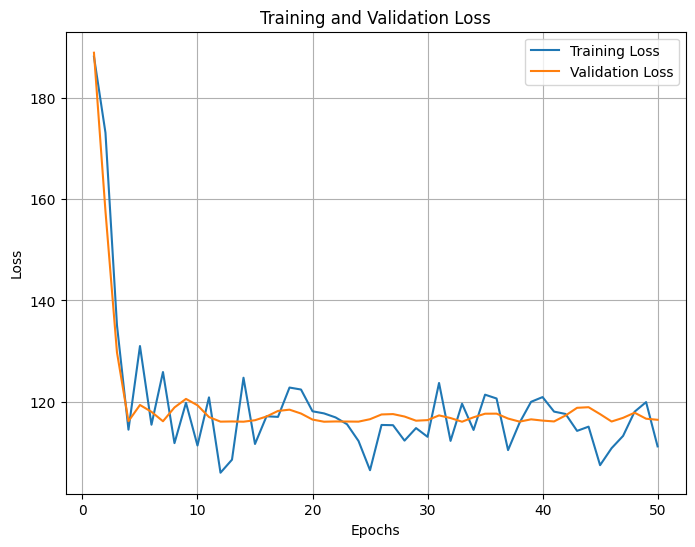

In [21]:
'''
Best trial:
  Value: 116.03802490234375
  Params:
    hidden_size1: 256
    hidden_size2: 64
    hidden_size3: 32
    num_layers: 3
    dropout_rate: 0.189667126879616
    lr: 0.0026448961708292864

'''

learning_rate = 0.0026448961708292864
num_epochs = 50
input_size = 13
output_size = 1

hidden_size1 = 256
hidden_size2 = 64
hidden_size3 = 32
output_size = 1
num_layers = 2
dropout_rate = 0.189667126879616

model = WeatherPredictorGRU(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, num_layers, dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data)

def train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader, device):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device).float(), targets.to(device).float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device).float(), targets.to(device).float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  # Plotting
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader, device)


In [22]:
def evaluate_and_collect_data(model, data_loader, device):
  model.eval()
  total_mae = 0
  count = 0
  predictions = []
  actuals = []

  with torch.no_grad():
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      outputs = model(inputs)
      mae = torch.abs(outputs - targets).mean()
      total_mae += mae.item()
      count += 1

      predictions.extend(outputs.view(-1).detach().cpu().numpy())
      actuals.extend(targets.view(-1).detach().cpu().numpy())


  avg_mae = total_mae / count
  return predictions, actuals, avg_mae

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

predictions, actuals, avg_mae = evaluate_and_collect_data(model, test_loader, device)
print(f'Mean Prediction Error: {avg_mae:.4f}')

Mean Prediction Error: 8.3941


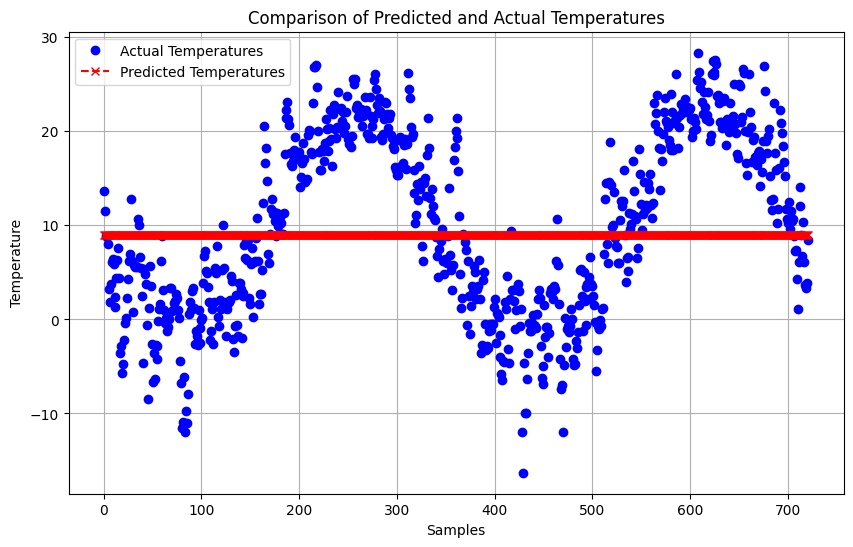

In [23]:
def plot_predictions_vs_actuals(predictions, actuals):
  plt.figure(figsize=(10, 6))
  plt.plot(actuals, label='Actual Temperatures', color='blue', marker='o', linestyle='')
  plt.plot(predictions, label='Predicted Temperatures', color='red', linestyle='--', marker='x')
  plt.title('Comparison of Predicted and Actual Temperatures')
  plt.xlabel('Samples')
  plt.ylabel('Temperature')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_predictions_vs_actuals(predictions, actuals)